In [64]:
import tweetnlp
import pandas as pd

In [65]:
# load model
model = tweetnlp.load_model('sentiment')  # Or `model = tweetnlp.Sentiment()`

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [109]:
# Load data
df_orig = pd.read_csv('twitter_validation.csv', names=['Twitter ID','Topic','Sentiment','Text'])
#df_orig = pd.read_csv('cleaned_tweets.csv', header=0, index_col=0)
df = df_orig.iloc[0:1000]

# Change Irrelevant label into Neutral as mentioned in the data set description.
def adjust_ori_sentiment(sentiment):
    if sentiment == "Irrelevant":
        #temp_str = "Neutral"
        temp_str = "Irrelevant"
        return temp_str
    else:
        return sentiment

df['Sentiment'] = df['Sentiment'].apply(adjust_ori_sentiment)
#df['Tidy_Text'] = df['Tidy_Text'].apply(str)
df

,Twitter ID,Topic,Sentiment,Text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [67]:
# Predict
def analysis(tweet):
    result = model.sentiment(tweet, return_probability=True)
    label = result.get('label')
    confidence = result.get('probability')[max(result.get('probability'), key=result.get('probability').get)]
    return label, confidence

# Check the accuracy
# def evalable(df):
#     good_label = 0
#     bad_label = 0
#     for i in range(df.shape[0]):
#         if str(df.iloc[i, 2]).lower() == str(df.iloc[i, 4]).lower():
#             good_label += 1
#         else:
#             bad_label += 1
#     return good_label, bad_label

def evalable(df):
    good_label = 0
    bad_label = 0
    irr_label = 0
    for i in range(df.shape[0]):
        if str(df.iloc[i, 2]).lower() == "irrelevant":
            irr_label += 1
        # iloc[i,2] is original label and iloc[i, 4] is generated label
        elif str(df.iloc[i, 2]).lower() == str(df.iloc[i, 4]).lower():
            good_label += 1
        else:
            bad_label += 1
    return good_label, bad_label, irr_label

def count_label(df):
    count_positive = df[df['Sentiment'] == 'Positive'].shape[0]
    count_negative = df[df['Sentiment'] == 'Negative'].shape[0]
    count_neutral = df[df['Sentiment'] == 'Neutral'].shape[0]
    count_irrelevant = df[df['Sentiment'] == 'Irrelevant'].shape[0]
    return count_positive, count_negative, count_neutral, count_irrelevant

In [68]:
# Execute
df_results = pd.DataFrame()
df_results['Result'] = df['Text'].apply(analysis)
#df_results['Result'] = df['Tidy_Text'].apply(analysis)

# Put results into data frame
testpd = pd.DataFrame(df_results['Result'].tolist())
label_list = testpd[0].tolist()
confidence_list = testpd[1].tolist()

df['Label'] = label_list
df['Confidence'] = confidence_list

In [69]:
df

,Twitter ID,Topic,Sentiment,Text,Label,Confidence
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...,negative,0.645820
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,neutral,0.738145
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,negative,0.936622
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",negative,0.961268
4,4433,Google,Neutral,Now the President is slapping Americans in the...,negative,0.782214
...,...,...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...,positive,0.950140
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,positive,0.972971
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...,negative,0.903055
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.,positive,0.908308


In [70]:
count_positive, count_negative, count_neutral, count_irrelevant = count_label(df)
print("There are 4 types of sentiment label in our data set, \nPositive:",count_positive, "Negative:",count_negative, "Neutral:",count_neutral, "Irrelevant:", count_irrelevant)

There are 4 types of sentiment label in our data set, 
Positive: 277 Negative: 266 Neutral: 285 Irrelevant: 172


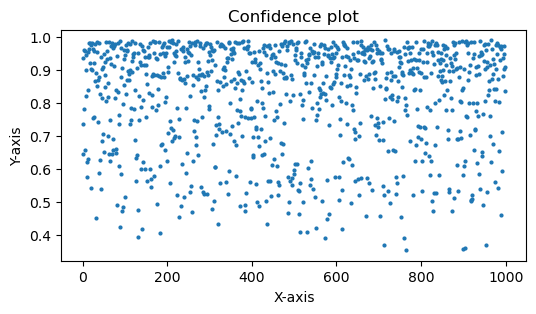

In [71]:
import matplotlib.pyplot as plt

# Set the figure size
fig = plt.figure(figsize=(6, 3))

# Plot the chart
plt.plot(df.index, df['Confidence'], marker='o', linestyle='', markersize=2)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Confidence plot')
plt.show()

In [73]:
# Evaluate the accuracy of
good_labels, bad_labels, irr_labels = evalable(df)
accuracy1 = good_labels / (good_labels + bad_labels)

In [74]:
# Keep high confidence predictions, might be able to use confidence score to filter data.
df_highc = df[df['Confidence'] > 0.9]
df_lowc = df[df['Confidence'] < 0.7]

In [75]:
# Evaluate the accuracy again
good_labels, bad_labels, irr_labels = evalable(df_highc)
accuracy2 = good_labels / (good_labels + bad_labels)

In [76]:
# Evaluate the accuracy again
good_labels, bad_labels, irr_labels = evalable(df_lowc)
accuracy3 = good_labels / (good_labels + bad_labels)

In [77]:
print("Total accuracy is: ", accuracy1, "\nAfter removing low confidence labels is: ", accuracy2, "\nAccuracy for low confidence labels is: ", accuracy3)

Total accuracy is:  0.6594202898550725 
After removing low confidence labels is:  0.7638483965014577 
Accuracy for low confidence labels is:  0.5102040816326531


In [104]:
df_trans_lowc_to_neutral = df
df_trans_lowc_to_neutral

,Twitter ID,Topic,Sentiment,Text,Label,Confidence
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...,Neutral,0.645820
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,Neutral,0.738145
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,negative,0.936622
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",negative,0.961268
4,4433,Google,Neutral,Now the President is slapping Americans in the...,Neutral,0.782214
...,...,...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...,positive,0.950140
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,positive,0.972971
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...,negative,0.903055
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.,positive,0.908308


In [105]:
df_trans_lowc_to_neutral.loc[df['Confidence'] < 0.4, 'Label'] = 'Neutral'
df_trans_lowc_to_neutral

,Twitter ID,Topic,Sentiment,Text,Label,Confidence
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...,Neutral,0.645820
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,Neutral,0.738145
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,negative,0.936622
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",negative,0.961268
4,4433,Google,Neutral,Now the President is slapping Americans in the...,Neutral,0.782214
...,...,...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...,positive,0.950140
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,positive,0.972971
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...,negative,0.903055
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.,positive,0.908308


In [106]:
# Evaluate the accuracy of
good_labels, bad_labels, irr_labels = evalable(df_trans_lowc_to_neutral)
accuracy1 = good_labels / (good_labels + bad_labels)
# Keep high confidence predictions, might be able to use confidence score to filter data.
df_highc_phase2 = df[df['Confidence'] > 0.9]
df_lowc_phase2 = df[df['Confidence'] < 0.7]
# Evaluate the accuracy again
good_labels, bad_labels, irr_labels = evalable(df_highc_phase2)
accuracy2 = good_labels / (good_labels + bad_labels)
# Evaluate the accuracy again
good_labels, bad_labels, irr_labels = evalable(df_lowc_phase2)
accuracy3 = good_labels / (good_labels + bad_labels)

In [107]:
print("Total accuracy is: ", accuracy1, "\nAfter removing low confidence labels is: ", accuracy2, "\nAccuracy for low confidence labels is: ", accuracy3)

Total accuracy is:  0.6207729468599034 
After removing low confidence labels is:  0.7638483965014577 
Accuracy for low confidence labels is:  0.4489795918367347
